gen	nevals	avg                                           	min                                     
0  	200   	[5.84827550e+02 3.86668517e+01 9.00000000e-02]	[406.55345143   2.81096857   0.        ]
1  	400   	[5.24870596e+02 2.50366397e+01 2.00000000e-01]	[384.15847886   2.81096857   0.        ]
2  	400   	[5.03803857e+02 1.74921271e+01 2.00000000e-01]	[374.81107201   1.01641944   0.        ]
3  	400   	[4.98284702e+02 1.26370414e+01 1.65000000e-01]	[374.81107201   1.01641944   0.        ]
4  	400   	[4.87216021e+02 1.20448194e+01 8.50000000e-02]	[3.74811072e+02 1.67752797e-01 0.00000000e+00]
5  	400   	[4.82358237e+02 1.03595925e+01 6.50000000e-02]	[3.73711426e+02 1.67752797e-01 0.00000000e+00]
6  	400   	[4.86496720e+02 7.52983929e+00 1.05000000e-01]	[3.24118775e+02 1.67752797e-01 0.00000000e+00]
7  	400   	[4.82073426e+02 6.58638055e+00 1.30000000e-01]	[3.24118775e+02 1.67752797e-01 0.00000000e+00]
8  	400   	[4.82440476e+02 5.56590064e+00 2.10000000e-01]	[3.24118775e+02 1.67752797e

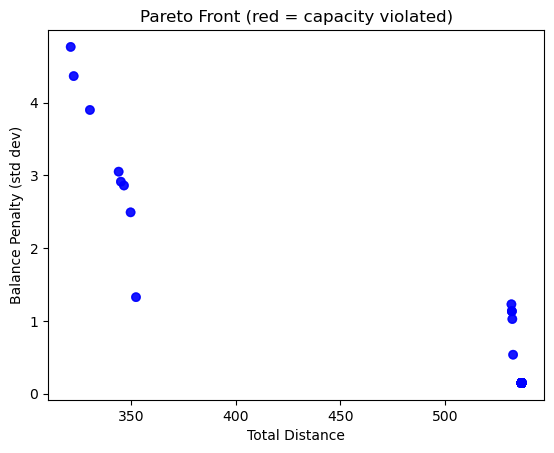

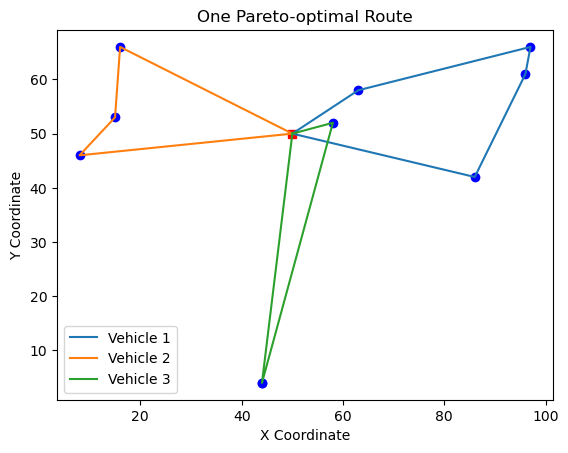

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# -----------------------------
# Problem Setup
# -----------------------------
num_locations = 10
locations = [(random.randint(0, 100), random.randint(0, 100)) for _ in range(num_locations)]
depot = (50, 50)
num_vehicles = 3

# Demands and capacity constraint
demands = [random.randint(1, 10) for _ in range(num_locations)]
vehicle_capacity = 25

# Precompute distance matrix
all_points = [depot] + locations
dist_matrix = np.zeros((len(all_points), len(all_points)))
for i, a in enumerate(all_points):
    for j, b in enumerate(all_points):
        dist_matrix[i, j] = np.linalg.norm(np.array(a) - np.array(b))

# -----------------------------
# Genetic Algorithm Setup
# -----------------------------
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0, -1.0))  # distance, balance, capacity_penalty
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(num_locations), num_locations)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# -----------------------------
# Fitness Function
# -----------------------------
def evalVRP(individual):
    total_distance = 0
    distances = []
    capacity_penalty = 0

    for i in range(num_vehicles):
        route_indices = [individual[j] for j in range(i, len(individual), num_vehicles)]
        route = [0] + [idx + 1 for idx in route_indices] + [0]  # +1 shift because depot is index 0

        # Route distance
        vehicle_distance = sum(dist_matrix[route[k], route[k + 1]] for k in range(len(route) - 1))
        total_distance += vehicle_distance
        distances.append(vehicle_distance)

        # Route capacity
        load = sum(demands[idx] for idx in route_indices)
        if load > vehicle_capacity:
            capacity_penalty += (load - vehicle_capacity)

    balance_penalty = np.std(distances)
    return total_distance, balance_penalty, capacity_penalty

# -----------------------------
# GA Operators
# -----------------------------
toolbox.register("evaluate", evalVRP)
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selNSGA2)

# -----------------------------
# Plotting Helpers
# -----------------------------
def plot_routes(individual, title="Routes"):
    plt.figure()
    for (x, y) in locations:
        plt.plot(x, y, 'bo')
    plt.plot(depot[0], depot[1], 'rs')

    for i in range(num_vehicles):
        route_indices = [individual[j] for j in range(i, len(individual), num_vehicles)]
        vehicle_route = [depot] + [locations[idx] for idx in route_indices] + [depot]
        plt.plot(*zip(*vehicle_route), '-', label=f"Vehicle {i+1}")

    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

def plot_pareto(pop):
    fits = [ind.fitness.values for ind in pop]
    d, b, c = zip(*fits)
    plt.scatter(d, b, c=["red" if p > 0 else "blue" for p in c], alpha=0.7)
    plt.xlabel("Total Distance")
    plt.ylabel("Balance Penalty (std dev)")
    plt.title("Pareto Front (red = capacity violated)")
    plt.show()

# -----------------------------
# Main Execution
# -----------------------------
def main():
    random.seed(42)
    pop = toolbox.population(n=200)
    hof = tools.ParetoFront()

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("min", np.min, axis=0)

    algorithms.eaMuPlusLambda(pop, toolbox, mu=200, lambda_=400, cxpb=0.7, mutpb=0.3, ngen=150,
                              stats=stats, halloffame=hof, verbose=True)

    # Plot Pareto front
    plot_pareto(pop)

    # Show one solution (first in hof)
    if hof:
        plot_routes(hof[0], "One Pareto-optimal Route")

    return pop, stats, hof

if __name__ == "__main__":
    main()
